<a href="https://colab.research.google.com/github/ritvikv03/AVSproj/blob/main/Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning Model: Clustering of Driving Behaviors with K-Means

Application in the Project:
*   **Unsupervised learning** is used when the dataset does not have labeled outputs. In autonomous driving, clustering can identify different driving patterns or behaviors based on sensor data (e.g., speed, acceleration, proximity to obstacles). This information can then be used to adapt driving strategies in different scenarios.
*   **K-Means Clustering**: A popular unsupervised learning algorithm that groups data points into clusters based on their features.



In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Step 1**: Generate Synthetic Time-Series Data

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Time settings
time_start = 0        # in seconds
time_end = 100        # in seconds
time_step = 0.5       # in seconds

# Generate time points
time_points = np.arange(time_start, time_end, time_step)
n_samples = len(time_points)

print("Total time points:", n_samples)


# Simulate front distances decreasing over time (e.g., approaching an obstacle)
front_distance = 50 - 0.4 * time_points + np.random.normal(0, 2, n_samples)
front_distance = np.clip(front_distance, 0, None)  # Ensure distances are non-negative

# Simulate left and right distances with slight variations
left_distance = 10 + np.sin(0.1 * time_points) * 2 + np.random.normal(0, 1, n_samples)
right_distance = 10 + np.cos(0.1 * time_points) * 2 + np.random.normal(0, 1, n_samples)

# Simulate relative speed (obstacle speed relative to vehicle)
relative_speed = -2 + 0.05 * time_points + np.random.normal(0, 0.5, n_samples)


# Create a DataFrame
data = pd.DataFrame({
    'time': time_points,
    'front_distance': front_distance,
    'left_distance': left_distance,
    'right_distance': right_distance,
    'relative_speed': relative_speed
})

# Ensure all distances are non-negative
data[['front_distance', 'left_distance', 'right_distance']] = data[['front_distance', 'left_distance', 'right_distance']].clip(lower=0)

data.head()


# Scenario: Sudden obstacle appears between time 30s and 40s
stop_indices = data[(data['time'] >= 30) & (data['time'] <= 40)].index
data.loc[stop_indices, 'front_distance'] = data.loc[stop_indices, 'front_distance'] - 15
data.loc[stop_indices, 'relative_speed'] = data.loc[stop_indices, 'relative_speed'] + 5

# Ensure distances are non-negative
data['front_distance'] = data['front_distance'].clip(lower=0)

Total time points: 200


**Step 2**: Data Visualization

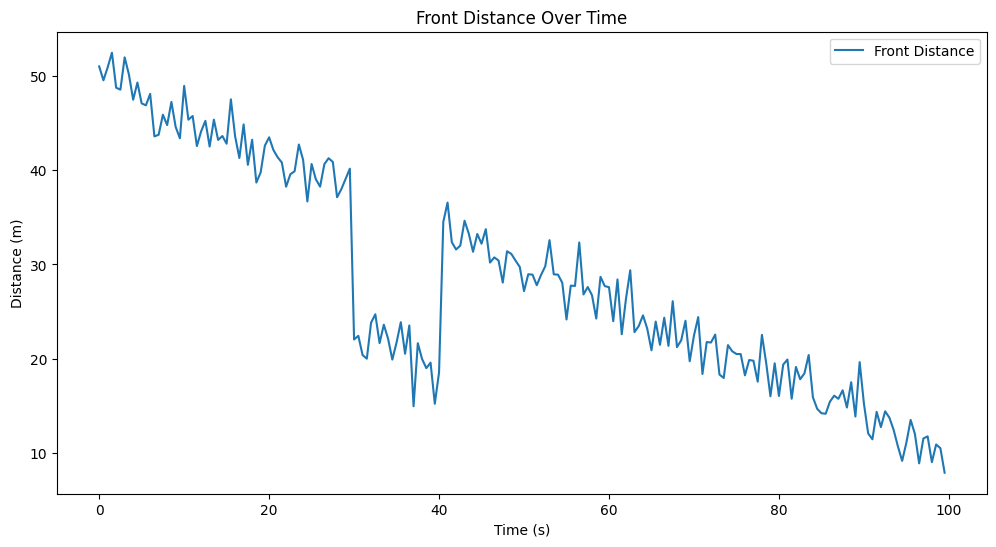

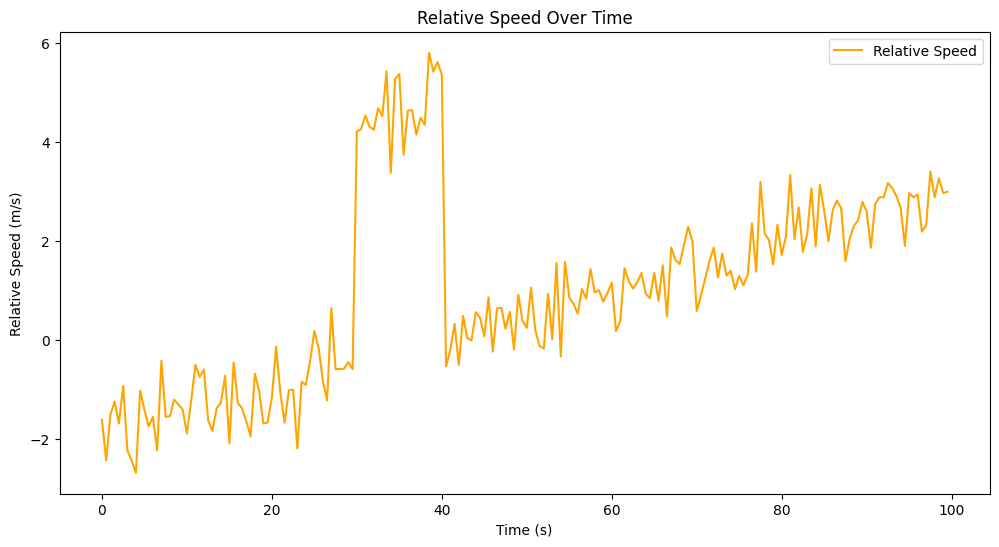

In [ ]:
# Plot front distance over time (Sensor Readings Over Time)
plt.figure(figsize=(12, 6))
plt.plot(data['time'], data['front_distance'], label='Front Distance')
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.title('Front Distance Over Time')
plt.legend()
plt.show()

# Plotting Relative Speed Over Time
plt.figure(figsize=(12, 6))
plt.plot(data['time'], data['relative_speed'], label='Relative Speed', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Relative Speed (m/s)')
plt.title('Relative Speed Over Time')
plt.legend()
plt.show()


**Step 3**: Applying K-Means Clustering

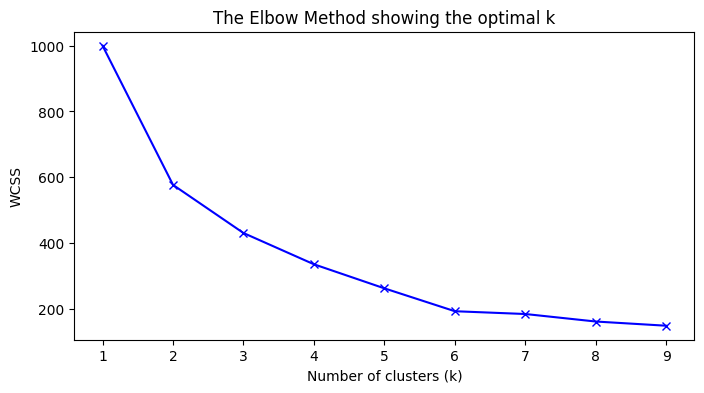

In [ ]:
from sklearn.preprocessing import StandardScaler

# Feature Scaling
features = ['time', 'front_distance', 'left_distance', 'right_distance', 'relative_speed']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features])

# Determining the Optimal Number of Clusters
wcss = []  # Within-cluster sum of squares
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(8, 4))
plt.plot(K, wcss, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Applying K-Means with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
data['cluster'] = clusters


**Step 4**: Interpreting the Clusters

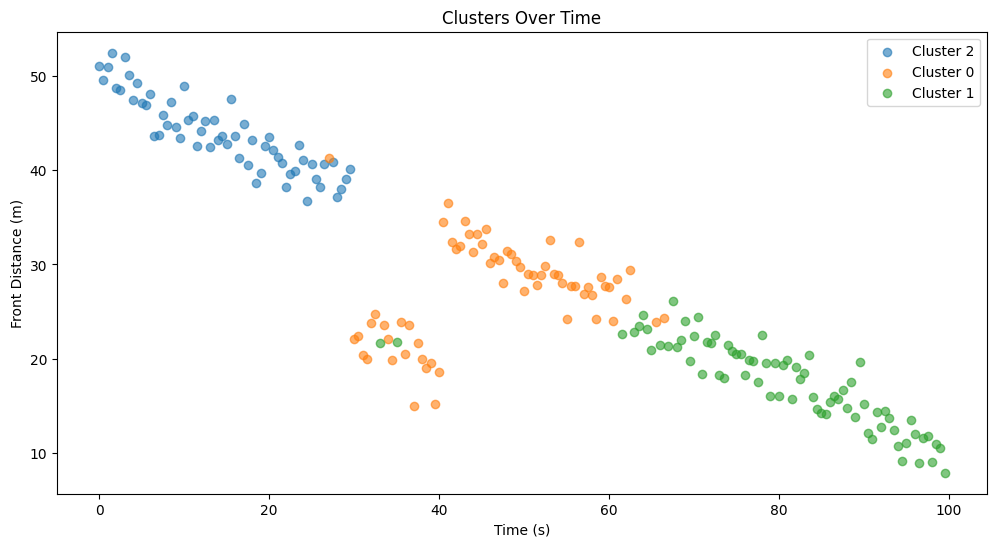

In [ ]:
# Cluster Centroids
# Inverse transform the centroids to original scale
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroid_df = pd.DataFrame(centroids, columns=features)
centroid_df['cluster'] = centroid_df.index
centroid_df

# Visualizaing Clusters Over Time
plt.figure(figsize=(12, 6))
for cluster in data['cluster'].unique():
    subset = data[data['cluster'] == cluster]
    plt.scatter(subset['time'], subset['front_distance'], label=f'Cluster {cluster}', alpha=0.6)
plt.xlabel('Time (s)')
plt.ylabel('Front Distance (m)')
plt.title('Clusters Over Time')
plt.legend()
plt.show()


**Step 5**: Determining When to Stop

Clusters where vehicle should consider stopping: []


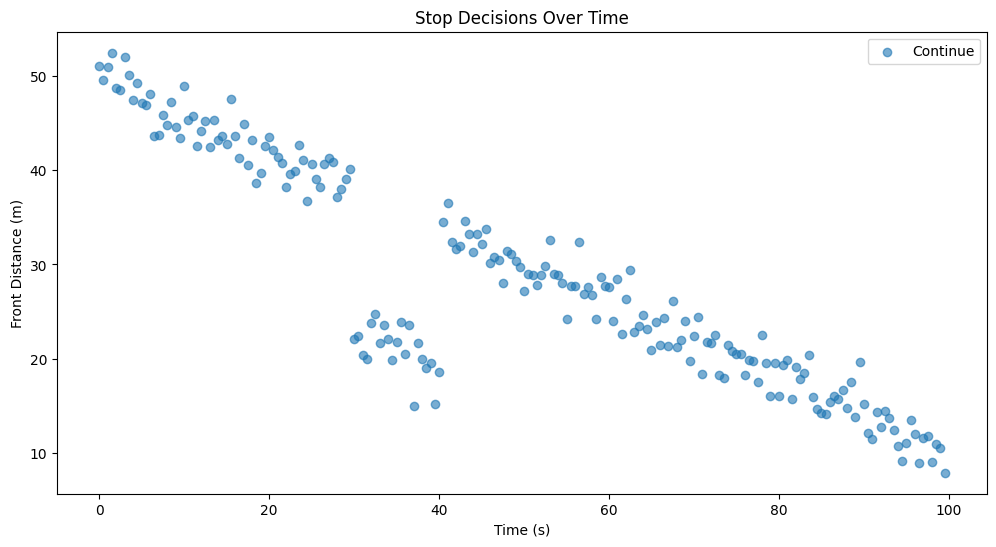

In [ ]:
# Analyze Cluster Characteristics
centroid_df[['cluster', 'time', 'front_distance', 'relative_speed']]

# We'll consider stopping when:
  # Front Distance is less than a threshold (e.g., 10 meters).
  # Relative Speed is high (obstacle approaching quickly).
  # Time is within certain intervals where obstacles are likely.


# Identify Clusters Meeting Stopping Criteria
# Define thresholds
front_distance_threshold = 10    # meters
relative_speed_threshold = 3     # m/s

# Identify clusters where stopping is necessary
stop_clusters = centroid_df[
    (centroid_df['front_distance'] <= front_distance_threshold) &
    (centroid_df['relative_speed'] >= relative_speed_threshold)
]['cluster'].tolist()

print("Clusters where vehicle should consider stopping:", stop_clusters)


# Assign Stop Decision to Data Points
data['stop_decision'] = data['cluster'].apply(lambda x: 'Stop' if x in stop_clusters else 'Continue')


# Visualize Stop Decisions Over Time
plt.figure(figsize=(12, 6))
for decision in data['stop_decision'].unique():
    subset = data[data['stop_decision'] == decision]
    plt.scatter(subset['time'], subset['front_distance'], label=f'{decision}', alpha=0.6)
plt.xlabel('Time (s)')
plt.ylabel('Front Distance (m)')
plt.title('Stop Decisions Over Time')
plt.legend()
plt.show()
